In [194]:
import warnings
warnings.filterwarnings('ignore')

In [195]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from clickhouse_driver import Client
from statistics import mean

#connect
from connect import client

### Выгрзим нужные данные

In [196]:
print('В БД monitoring есть таблицы:')
print(client.execute('SHOW TABLES'))

В БД monitoring есть таблицы:
[('history',), ('history2',), ('history_nifi',), ('history_opt1',), ('history_opt2',)]


Мы будем работать с таблицей history

bytes_on_disk (UInt64) – общий размер всех файлов кусков данных в байтах.

data_compressed_bytes (UInt64) – общий размер сжатой информации в куске данных. Размер всех дополнительных файлов (например, файлов с засечками) не учитывается.

data_uncompressed_bytes (UInt64) – общий размер распакованной информации куска данных. Размер всех дополнительных файлов (например, файлов с засечками) не учитывается.

In [197]:
client.execute('''SELECT table , round(sum(data_compressed_bytes) /1024/1024/1024, 2) as size_gb
                FROM system.parts
                WHERE active
                GROUP BY table
                ORDER BY size_gb DESC''')

[('query_log', 118.34),
 ('query_thread_log', 104.4),
 ('history', 62.25),
 ('history_opt1', 17.05),
 ('history_opt2', 16.76),
 ('history2', 9.42),
 ('query_log_0', 6.68),
 ('query_thread_log_0', 6.0),
 ('metric_log', 3.04),
 ('metric_log_0', 0.47),
 ('trace_log', 0.26),
 ('asynchronous_metric_log', 0.1),
 ('readings', 0.0),
 ('crash_log', 0.0)]

Вес этой таблицы 62.13 ГБ, поэтому загрузить её всю в dataframe не получится.сначала визуализуруем её часть, чтобы лучше понять как выглядит эта таблица

In [198]:
result, column = client.execute("SELECT * FROM history LIMIT 1000",
                               with_column_types = True)

In [199]:
col = []
for c in column:
    col.append(c[0])

data = pd.DataFrame(result, columns=col)
data

host                                     name  \
0    Mskmgt1325_Vityaz                             lkviz_online   
1    Mskmgt1209_Vityaz                             lkviz_online   
2    Mskmgt1253_Vityaz                               pvi_online   
3    Mskmgt1061_Vityaz                             lkviz_online   
4    Mskmgt1341_Vityaz                               pvi_online   
5    Mskmgt1130_Vityaz                             lkviz_online   
6    Mskmgt1249_Vityaz                               pvi_online   
7    Mskmgt1263_Vityaz                             lkviz_online   
8    Mskmgt1351_Vityaz                             lkviz_online   
9    Mskmgt1001_Vityaz                             lkviz_online   
10   Mskmgt1262_Vityaz                             lkviz_online   
11   Mskmgt1158_Vityaz                             lkviz_online   
12   Mskmgt1142_Vityaz                               pvi_online   
13   Mskmgt1374_Vityaz                               pvi_online   
14   Mskmgt1155_Vityaz                               pvi_online   
15   Mskmgt1173_Vityaz                             lkviz_online   
16   Mskmgt1227_Vityaz                             lkviz_online   
17   Mskmgt1218_Vityaz                               pvi_online   
18   Mskmgt1137_Vityaz                               pvi_online   
19   Mskmgt1071_Vityaz                             lkviz_online   
20   Mskmgt1198_Vityaz                             lkviz_online   
21   Mskmgt1318_Vityaz                                    Speed   
22   Mskmgt1267_Vityaz                               pvi_online   
23   Mskmgt1175_Vityaz                               pvi_online   
24   Mskmgt1279_Vityaz                               pvi_online   
25   Mskmgt1005_Vityaz                               pvi_online   
26   Mskmgt1318_Vityaz                             lkviz_online   
27   Mskmgt1003_Vityaz                               pvi_online   
28   Mskmgt1201_Vityaz                             lkviz_online   
29   Mskmgt1303_Vityaz                             lkviz_online   
30   Mskmgt1092_Vityaz                               pvi_online   
31   Mskmgt1121_Vityaz                             lkviz_online   
32   Mskmgt1042_Vityaz                             lkviz_online   
33   Mskmgt1082_Vityaz                               pvi_online   
34   Mskmgt1140_Vityaz                             lkviz_online   
35   Mskmgt1371_Vityaz                             lkviz_online   
36   Mskmgt1284_Vityaz                               pvi_online   
37   Mskmgt1087_Vityaz                               pvi_online   
38   Mskmgt1144_Vityaz                               pvi_online   
39   Mskmgt1253_Vityaz                                online_tr   
40   Mskmgt1249_Vityaz                                online_tr   
41   Mskmgt1341_Vityaz                                online_tr   
42   Mskmgt1142_Vityaz                                online_tr   
43   Mskmgt1344_Vityaz                                 latitude   
44   Mskmgt1344_Vityaz                                longitude   
45   Mskmgt1155_Vityaz                                online_tr   
46   Mskmgt1344_Vityaz                                     hdop   
47   Mskmgt1344_Vityaz                             hdopInMeters   
48   Mskmgt1344_Vityaz                            numSatellites   
49   Mskmgt1374_Vityaz                                online_tr   
50   Mskmgt1175_Vityaz                                online_tr   
51   Mskmgt1137_Vityaz                                online_tr   
52   Mskmgt1350_Vityaz                            numSatellites   
53   Mskmgt1218_Vityaz                                online_tr   
54   Mskmgt1350_Vityaz                             hdopInMeters   
55   Mskmgt1279_Vityaz                                online_tr   
56   Mskmgt1350_Vityaz                                     hdop   
57   Mskmgt1005_Vityaz                                online_tr   
58   Mskmgt1267_Vityaz                                online_tr  

In [200]:
print(f"Таблица history начала заполняться с {data.clock.min()}")

Таблица history начала заполняться с 2020-10-17 03:00:00


In [201]:
cnt = client.execute('''select sum(data_compressed_bytes)/1024/1024 size, round((sum(data_uncompressed_bytes))/1024/1024) ub, sum(rows), partition, count() part_count, database,table
    FROM system.parts 
    where active = 1 and table like '%' and database like '%' 
    group by database,table, partition''')

##### Удалим ненужные таблицы

In [202]:
len(cnt)

902

In [203]:
indx = []
for i in range(len(cnt)):
    if 'monitoring' not in cnt[i] or 'history' not in cnt[i]:
        indx.append(i)

In [204]:
for i in range(len(indx)):
    cnt.pop(indx[i] - i)

In [205]:
len(cnt)

383

In [206]:
cnt

[(212.2736644744873, 1660.0, 35992426, '20210628', 4, 'monitoring', 'history'),
 (207.22973537445068,
  1788.0,
  38685305,
  '20210923',
  7,
  'monitoring',
  'history'),
 (278.05360889434814,
  1510.0,
  39259987,
  '20201023',
  3,
  'monitoring',
  'history'),
 (168.5541067123413, 1355.0, 29415061, '20210503', 4, 'monitoring', 'history'),
 (148.5323724746704, 1001.0, 26454961, '20210313', 3, 'monitoring', 'history'),
 (204.7619514465332, 1729.0, 37422233, '20211011', 6, 'monitoring', 'history'),
 (153.55846691131592,
  1205.0,
  26154175,
  '20210717',
  5,
  'monitoring',
  'history'),
 (4.8502912521362305, 68.0, 1572480, '20210107', 1, 'monitoring', 'history'),
 (203.7477626800537, 1644.0, 35698808, '20210420', 4, 'monitoring', 'history'),
 (218.6510467529297, 1693.0, 36712769, '20210727', 3, 'monitoring', 'history'),
 (163.58085441589355,
  1323.0,
  28749313,
  '20210410',
  3,
  'monitoring',
  'history'),
 (162.04300498962402,
  1114.0,
  28453923,
  '20201130',
  2,
  'moni

##### Вынесем размер БД

In [207]:
bd_size = []

for i in range(len(cnt)):
    bd_size.append(cnt[i][0])

bd_size

[212.2736644744873,
 207.22973537445068,
 278.05360889434814,
 168.5541067123413,
 148.5323724746704,
 204.7619514465332,
 153.55846691131592,
 4.8502912521362305,
 203.7477626800537,
 218.6510467529297,
 163.58085441589355,
 162.04300498962402,
 213.81815814971924,
 186.36906242370605,
 214.43076038360596,
 205.079909324646,
 218.92724895477295,
 216.26010704040527,
 225.95868968963623,
 212.7287187576294,
 160.38616180419922,
 152.21275901794434,
 224.88485622406006,
 180.94735431671143,
 202.37097930908203,
 53.21450138092041,
 156.8576078414917,
 1.401803970336914,
 144.71291637420654,
 157.85183715820312,
 0.16004562377929688,
 203.27069187164307,
 207.56662368774414,
 213.9869899749756,
 250.38094902038574,
 209.29601764678955,
 4.889523506164551,
 4.908228874206543,
 197.42871761322021,
 262.0088405609131,
 201.11246585845947,
 198.96547985076904,
 167.2586441040039,
 160.20353412628174,
 211.09990978240967,
 4.86769962310791,
 256.11662006378174,
 222.74213027954102,
 4.8599309

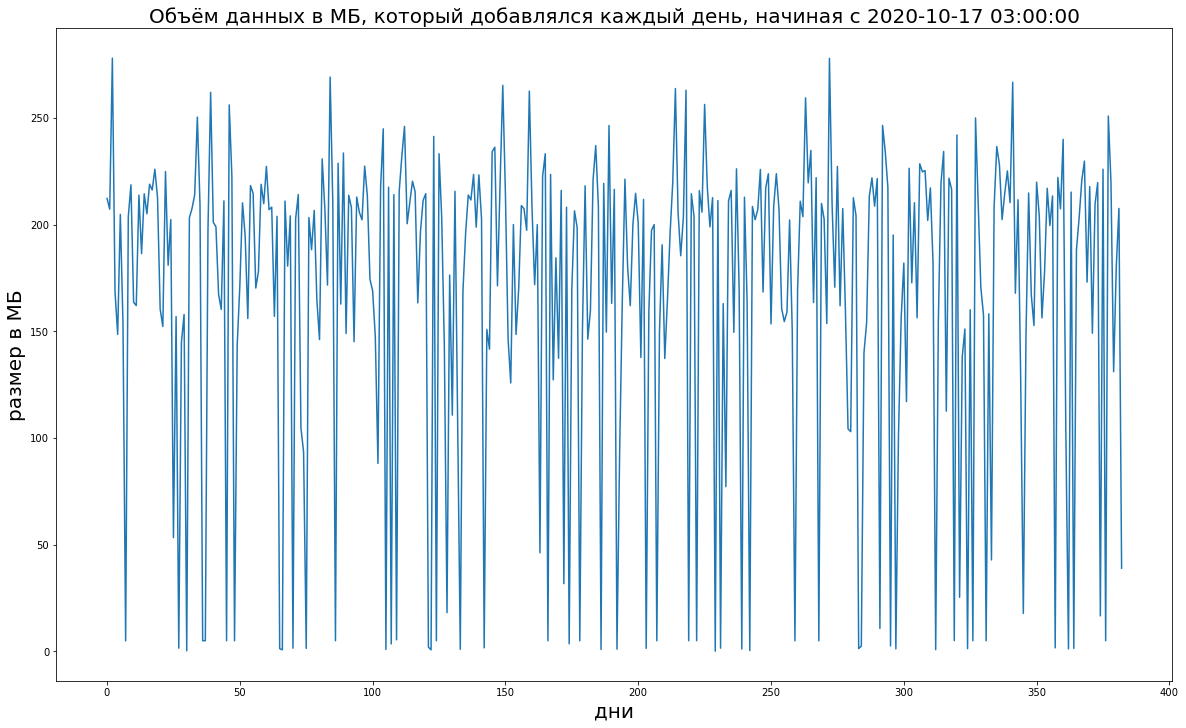

In [208]:
plt.figure(figsize = (20, 12))

plt.plot(range(383), bd_size)
plt.xlabel("дни", fontsize = 20)
plt.ylabel("размер в МБ", fontsize = 20)
plt.title(f"Объём данных в МБ, который добавлялся каждый день, начиная с {data.clock.min()}", fontsize = 20)

plt.show()

##### Теперь объединим данные и посмотрим на размер базы данных каждый день/неделю( рост объёма таблицы )

In [209]:
day = []
val = 0

for i in range(len(bd_size)):
    val += bd_size[i]
    day.append(val)

day

[212.2736644744873,
 419.503399848938,
 697.5570087432861,
 866.1111154556274,
 1014.6434879302979,
 1219.405439376831,
 1372.963906288147,
 1377.8141975402832,
 1581.561960220337,
 1800.2130069732666,
 1963.7938613891602,
 2125.836866378784,
 2339.6550245285034,
 2526.0240869522095,
 2740.4548473358154,
 2945.5347566604614,
 3164.4620056152344,
 3380.7221126556396,
 3606.680802345276,
 3819.4095211029053,
 3979.7956829071045,
 4132.008441925049,
 4356.893298149109,
 4537.84065246582,
 4740.211631774902,
 4793.426133155823,
 4950.283740997314,
 4951.685544967651,
 5096.398461341858,
 5254.250298500061,
 5254.41034412384,
 5457.681035995483,
 5665.2476596832275,
 5879.234649658203,
 6129.615598678589,
 6338.911616325378,
 6343.801139831543,
 6348.7093687057495,
 6546.13808631897,
 6808.146926879883,
 7009.259392738342,
 7208.224872589111,
 7375.483516693115,
 7535.687050819397,
 7746.786960601807,
 7751.654660224915,
 8007.771280288696,
 8230.513410568237,
 8235.373341560364,
 8378.8157

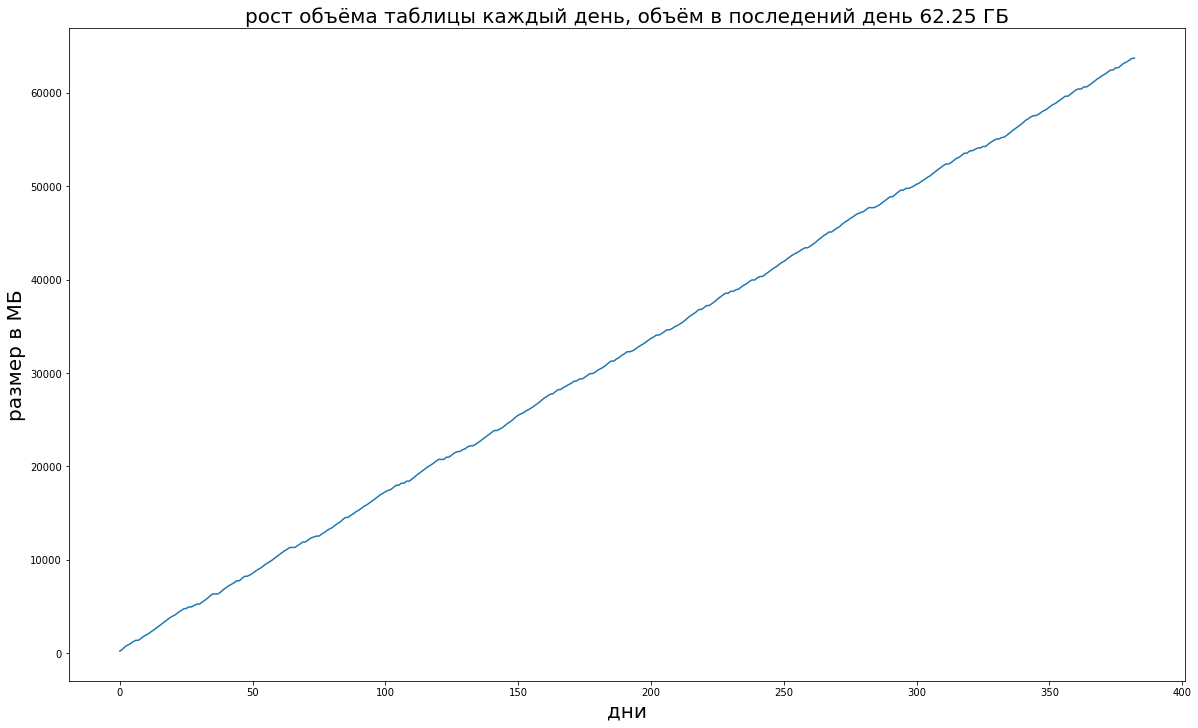

In [210]:
plt.figure(figsize = (20, 12))

plt.plot(range(383), day)
plt.xlabel("дни", fontsize = 20)
plt.ylabel("размер в МБ", fontsize = 20)
plt.title(f"рост объёма таблицы каждый день, объём в последений день {round(day[len(day) - 1]/1024, 2)} ГБ", fontsize = 20)

plt.show()

In [211]:
week = []

for i in range(0, len(day), 7):
    week.append(day[i])

week.append(63619.581464767456)

week

[212.2736644744873,
 1377.8141975402832,
 2740.4548473358154,
 4132.008441925049,
 5096.398461341858,
 6338.911616325378,
 7375.483516693115,
 8378.815789222717,
 9714.354915618896,
 11120.49820137024,
 11923.273377418518,
 12931.01099395752,
 14327.490743637085,
 15530.442172050476,
 16945.59066772461,
 17987.792503356934,
 19121.933735847473,
 20539.788232803345,
 21439.770099639893,
 22211.13334751129,
 23646.61351776123,
 24784.99337863922,
 26105.190363883972,
 27531.447504997253,
 28589.062987327576,
 29540.0661277771,
 30624.97593688965,
 31907.633282661438,
 32947.091031074524,
 34075.35214328766,
 35114.056829452515,
 36553.06170082092,
 37666.01069831848,
 38764.22841644287,
 39976.25520801544,
 40971.95382976532,
 42393.07085418701,
 43431.22150802612,
 44892.46410369873,
 46172.69587993622,
 47307.55415534973,
 48235.0829372406,
 49596.25985908508,
 50351.638414382935,
 51795.873047828674,
 53006.355432510376,
 53967.28873062134,
 54915.956996917725,
 55952.60029602051,
 57

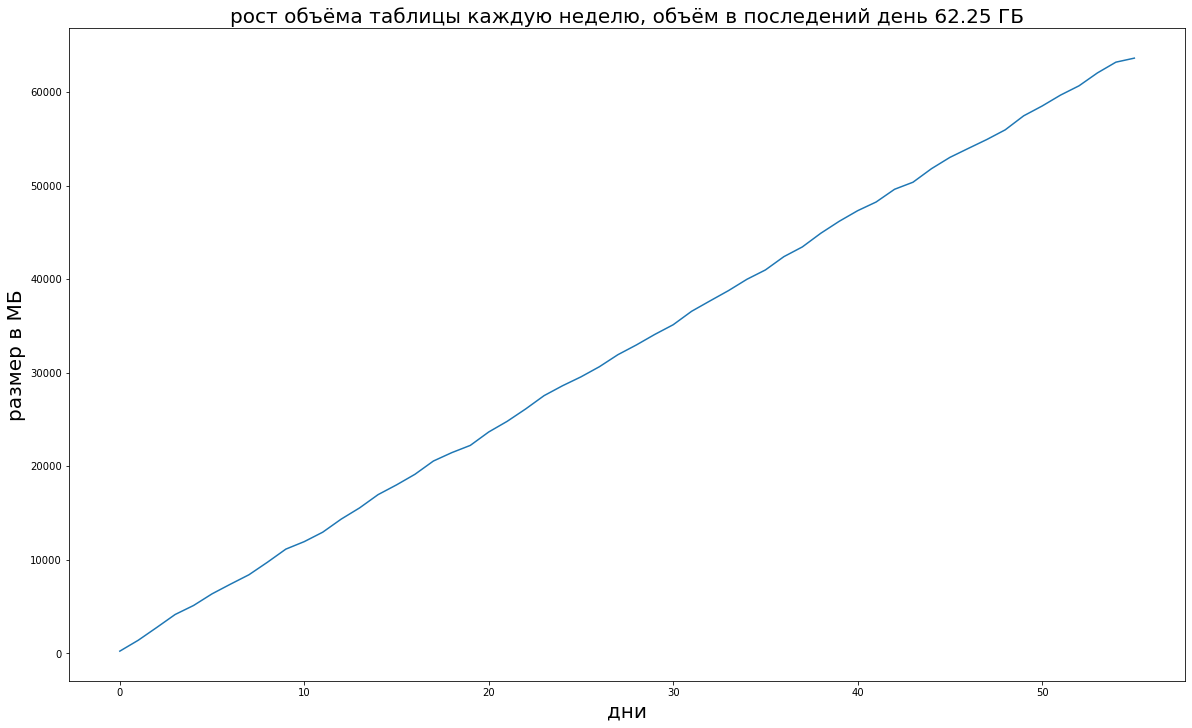

In [212]:
plt.figure(figsize = (20, 12))

plt.plot(range(len(week)), week)
plt.xlabel("дни", fontsize = 20)
plt.ylabel("размер в МБ", fontsize = 20)
plt.title(f"рост объёма таблицы каждую неделю, объём в последений день {round(day[len(day) - 1]/1024, 2)} ГБ", fontsize = 20)

plt.show()

### Посчитаем количество метрик(количество строк) за час в каждом месяцe, начиная с 2020-10-17 03:00:00

создам массив из дат, в котором будут даты с 2020-10-17 03:00:00 по сегодняшний момент с шагом в 1 час
первая дата: 2020-10-17 03:00:00
последняя дата: 2021-11-15 03:00:00

In [213]:
# import datetime, fromisoformat
from datetime import *
base = datetime.fromisoformat('2021-11-15 03:00:00')
date_list = [base - timedelta(hours=x) for x in range(9457)]
date_list

[datetime.datetime(2021, 11, 15, 3, 0),
 datetime.datetime(2021, 11, 15, 2, 0),
 datetime.datetime(2021, 11, 15, 1, 0),
 datetime.datetime(2021, 11, 15, 0, 0),
 datetime.datetime(2021, 11, 14, 23, 0),
 datetime.datetime(2021, 11, 14, 22, 0),
 datetime.datetime(2021, 11, 14, 21, 0),
 datetime.datetime(2021, 11, 14, 20, 0),
 datetime.datetime(2021, 11, 14, 19, 0),
 datetime.datetime(2021, 11, 14, 18, 0),
 datetime.datetime(2021, 11, 14, 17, 0),
 datetime.datetime(2021, 11, 14, 16, 0),
 datetime.datetime(2021, 11, 14, 15, 0),
 datetime.datetime(2021, 11, 14, 14, 0),
 datetime.datetime(2021, 11, 14, 13, 0),
 datetime.datetime(2021, 11, 14, 12, 0),
 datetime.datetime(2021, 11, 14, 11, 0),
 datetime.datetime(2021, 11, 14, 10, 0),
 datetime.datetime(2021, 11, 14, 9, 0),
 datetime.datetime(2021, 11, 14, 8, 0),
 datetime.datetime(2021, 11, 14, 7, 0),
 datetime.datetime(2021, 11, 14, 6, 0),
 datetime.datetime(2021, 11, 14, 5, 0),
 datetime.datetime(2021, 11, 14, 4, 0),
 datetime.datetime(2021, 1

Создадим функцию, которая будет создавать массив из количества метрик(строк) за каждый час за весь период

In [214]:
def metrics():
    all_metrics_in_hour = []
    
    for i in range(1, 9457):
        all_metrics_in_hour.append(client.execute(f"SELECT count() FROM history WHERE clock < '{date_list[len(date_list) - (i + 1)]}' AND clock >= '{date_list[len(date_list) - i]}'"))    
    
    return all_metrics_in_hour

Вывовем её и положим все метрики в список

In [215]:
%%time

all_metrics = metrics()

Wall time: 6min 10s


In [216]:
metric = []

for i in range(len(all_metrics)):
    metric.append(all_metrics[i][0])
    
metric

[(124232,),
 (368952,),
 (784204,),
 (1034662,),
 (1355736,),
 (1457004,),
 (1493244,),
 (1513662,),
 (1509557,),
 (1505373,),
 (1493547,),
 (1499771,),
 (1486266,),
 (1513101,),
 (1496111,),
 (1536645,),
 (1484431,),
 (1567461,),
 (1440069,),
 (1214075,),
 (1027923,),
 (873098,),
 (566287,),
 (237179,),
 (133566,),
 (375282,),
 (788796,),
 (1051043,),
 (1367561,),
 (1483978,),
 (1466379,),
 (1507665,),
 (1551895,),
 (1529125,),
 (1530908,),
 (1545732,),
 (1561330,),
 (1571789,),
 (1542384,),
 (1542487,),
 (1540509,),
 (1586359,),
 (1471081,),
 (1276868,),
 (1057351,),
 (888277,),
 (595924,),
 (265104,),
 (122016,),
 (339420,),
 (970696,),
 (1740418,),
 (2015936,),
 (2018198,),
 (2003152,),
 (2008911,),
 (1977031,),
 (1911221,),
 (1846784,),
 (1819327,),
 (1896913,),
 (2022264,),
 (2030324,),
 (2105196,),
 (2000820,),
 (2025672,),
 (1946683,),
 (1736829,),
 (1382919,),
 (1008479,),
 (627740,),
 (282319,),
 (131355,),
 (407090,),
 (1057656,),
 (1737063,),
 (1969608,),
 (1986076,),
 (196

In [217]:
date_list = date_list[::-1]

##### График метрик за все дни с периодом в час

1) График, где показано количество метрик за час

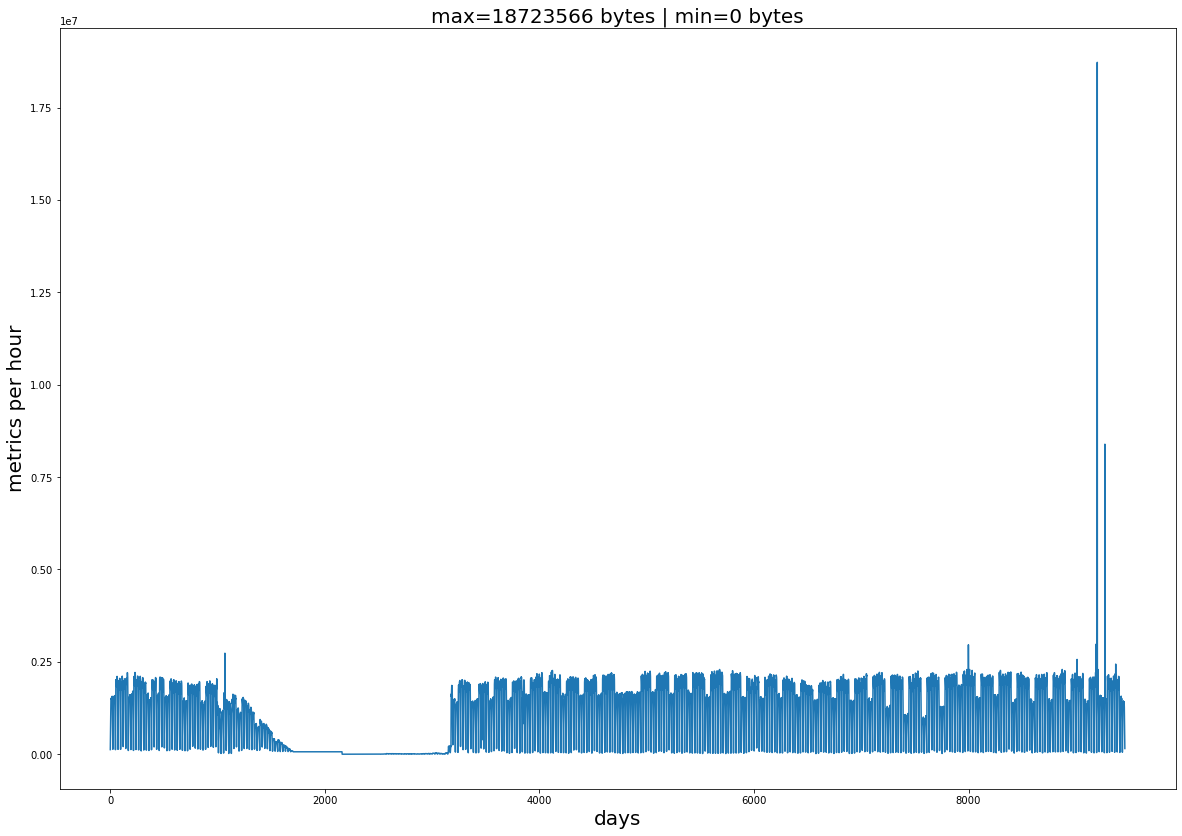

In [218]:
plt.figure(figsize = (20, 14))

plt.plot(range(1, len(metric) + 1), metric)
plt.xlabel("days", fontsize = 20)
plt.ylabel("metrics per hour", fontsize = 20)
plt.title(f"max={max(metric)[0]} bytes | min={min(metric)[0]} bytes", fontsize = 20)

plt.show()

2) Построим графики, где будет показано нарастающее количество метрик в час, то есть в конце мы увидем суммарное количество метрик за весь период

In [219]:
all_time_metrics = []
val = 0

for i in range(len(metric)):
    val += metric[i][0]
    all_time_metrics.append(val)

all_time_metrics

[124232,
 493184,
 1277388,
 2312050,
 3667786,
 5124790,
 6618034,
 8131696,
 9641253,
 11146626,
 12640173,
 14139944,
 15626210,
 17139311,
 18635422,
 20172067,
 21656498,
 23223959,
 24664028,
 25878103,
 26906026,
 27779124,
 28345411,
 28582590,
 28716156,
 29091438,
 29880234,
 30931277,
 32298838,
 33782816,
 35249195,
 36756860,
 38308755,
 39837880,
 41368788,
 42914520,
 44475850,
 46047639,
 47590023,
 49132510,
 50673019,
 52259378,
 53730459,
 55007327,
 56064678,
 56952955,
 57548879,
 57813983,
 57935999,
 58275419,
 59246115,
 60986533,
 63002469,
 65020667,
 67023819,
 69032730,
 71009761,
 72920982,
 74767766,
 76587093,
 78484006,
 80506270,
 82536594,
 84641790,
 86642610,
 88668282,
 90614965,
 92351794,
 93734713,
 94743192,
 95370932,
 95653251,
 95784606,
 96191696,
 97249352,
 98986415,
 100956023,
 102942099,
 104909618,
 106895635,
 108864600,
 110722188,
 112458042,
 114186862,
 116007704,
 117961555,
 120001002,
 122053018,
 124093710,
 126136173,
 128108

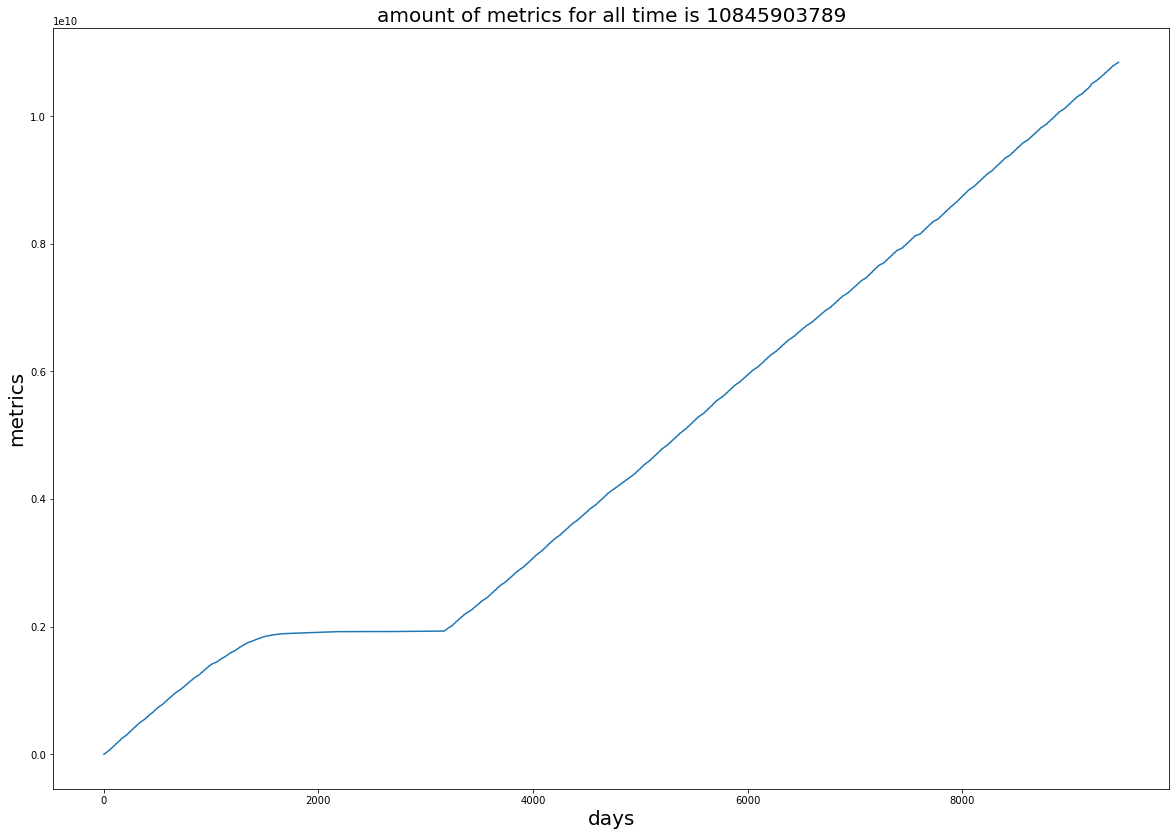

In [220]:
plt.figure(figsize = (20, 14))

plt.plot(range(1, len(metric) + 1), all_time_metrics)
plt.xlabel("days", fontsize = 20)
plt.ylabel("metrics", fontsize = 20)
plt.title(f"amount of metrics for all time is {all_time_metrics[len(all_time_metrics) - 1]}", fontsize = 20)

plt.show()

##### Создадим таблицу с метриками за каждый час за всё время

В ней показан период расчёта количество метрик

In [221]:
df_dict = {
    "from": date_list[:len(date_list)-1],
    "to": date_list[1:],
    "metrics": [val[0] for val in metric]
}

df = pd.DataFrame(df_dict)

df

from                  to   metrics
0    2020-10-17 03:00:00 2020-10-17 04:00:00    124232
1    2020-10-17 04:00:00 2020-10-17 05:00:00    368952
2    2020-10-17 05:00:00 2020-10-17 06:00:00    784204
3    2020-10-17 06:00:00 2020-10-17 07:00:00   1034662
4    2020-10-17 07:00:00 2020-10-17 08:00:00   1355736
5    2020-10-17 08:00:00 2020-10-17 09:00:00   1457004
6    2020-10-17 09:00:00 2020-10-17 10:00:00   1493244
7    2020-10-17 10:00:00 2020-10-17 11:00:00   1513662
8    2020-10-17 11:00:00 2020-10-17 12:00:00   1509557
9    2020-10-17 12:00:00 2020-10-17 13:00:00   1505373
10   2020-10-17 13:00:00 2020-10-17 14:00:00   1493547
11   2020-10-17 14:00:00 2020-10-17 15:00:00   1499771
12   2020-10-17 15:00:00 2020-10-17 16:00:00   1486266
13   2020-10-17 16:00:00 2020-10-17 17:00:00   1513101
14   2020-10-17 17:00:00 2020-10-17 18:00:00   1496111
15   2020-10-17 18:00:00 2020-10-17 19:00:00   1536645
16   2020-10-17 19:00:00 2020-10-17 20:00:00   1484431
17   2020-10-17 20:00:00 2020-10-17 21:00:00   1567461
18   2020-10-17 21:00:00 2020-10-17 22:00:00   1440069
19   2020-10-17 22:00:00 2020-10-17 23:00:00   1214075
20   2020-10-17 23:00:00 2020-10-18 00:00:00   1027923
21   2020-10-18 00:00:00 2020-10-18 01:00:00    873098
22   2020-10-18 01:00:00 2020-10-18 02:00:00    566287
23   2020-10-18 02:00:00 2020-10-18 03:00:00    237179
24   2020-10-18 03:00:00 2020-10-18 04:00:00    133566
25   2020-10-18 04:00:00 2020-10-18 05:00:00    375282
26   2020-10-18 05:00:00 2020-10-18 06:00:00    788796
27   2020-10-18 06:00:00 2020-10-18 07:00:00   1051043
28   2020-10-18 07:00:00 2020-10-18 08:00:00   1367561
29   2020-10-18 08:00:00 2020-10-18 09:00:00   1483978
30   2020-10-18 09:00:00 2020-10-18 10:00:00   1466379
31   2020-10-18 10:00:00 2020-10-18 11:00:00   1507665
32   2020-10-18 11:00:00 2020-10-18 12:00:00   1551895
33   2020-10-18 12:00:00 2020-10-18 13:00:00   1529125
34   2020-10-18 13:00:00 2020-10-18 14:00:00   1530908
35   2020-10-18 14:00:00 2020-10-18 15:00:00   1545732
36   2020-10-18 15:00:00 2020-10-18 16:00:00   1561330
37   2020-10-18 16:00:00 2020-10-18 17:00:00   1571789
38   2020-10-18 17:00:00 2020-10-18 18:00:00   1542384
39   2020-10-18 18:00:00 2020-10-18 19:00:00   1542487
40   2020-10-18 19:00:00 2020-10-18 20:00:00   1540509
41   2020-10-18 20:00:00 2020-10-18 21:00:00   1586359
42   2020-10-18 21:00:00 2020-10-18 22:00:00   1471081
43   2020-10-18 22:00:00 2020-10-18 23:00:00   1276868
44   2020-10-18 23:00:00 2020-10-19 00:00:00   1057351
45   2020-10-19 00:00:00 2020-10-19 01:00:00    888277
46   2020-10-19 01:00:00 2020-10-19 02:00:00    595924
47   2020-10-19 02:00:00 2020-10-19 03:00:00    265104
48   2020-10-19 03:00:00 2020-10-19 04:00:00    122016
49   2020-10-19 04:00:00 2020-10-19 05:00:00    339420
50   2020-10-19 05:00:00 2020-10-19 06:00:00    970696
51   2020-10-19 06:00:00 2020-10-19 07:00:00   1740418
52   2020-10-19 07:00:00 2020-10-19 08:00:00   2015936
53   2020-10-19 08:00:00 2020-10-19 09:00:00   2018198
54   2020-10-19 09:00:00 2020-10-19 10:00:00   2003152
55   2020-10-19 10:00:00 2020-10-19 11:00:00   2008911
56   2020-10-19 11:00:00 2020-10-19 12:00:00   1977031
57   2020-10-19 12:00:00 2020-10-19 13:00:00   1911221
58   2020-10-19 13:00:00 2020-10-19 14:00:00   1846784
59   2020-10-19 14:00:00 2020-10-19 15:00:00   1819327
60   2020-10-19 15:00:00 2020-10-19 16:00:00   1896913
61   2020-10-19 16:00:00 2020-10-19 17:00:00   2022264
62   2020-10-19 17:00:00 2020-10-19 18:00:00   2030324
63   2020-10-19 18:00:00 2020-10-19 19:00:00   2105196
64   2020-10-19 19:00:00 2020-10-19 20:00:00   2000820
65   2020-10-19 20:00:00 2020-10-19 21:00:00   2025672
66   2020-10-19 21:00:00 2020-10-19 22:00:00   1946683
67   2020-10-19 22:00:00 2020-10-19 23:00:00   1736829
68   2020-10-19 23:00:00 2020-10-20 00:00:00   1382919
69   2020-10-20 00:00:00 2020-10-20 01:00:00   1008479
70   2020-10-20 01:00:00 2020-10-20 02:00:00    627740
71   2020-10-20 02:00:00 2020-10-20 03:00:00    282319
72   

Вывод всех дней, когда metrics = 0

In [222]:
df.loc[df['metrics'] == 0]

from                  to  metrics
2160 2021-01-15 03:00:00 2021-01-15 04:00:00        0
2161 2021-01-15 04:00:00 2021-01-15 05:00:00        0
2162 2021-01-15 05:00:00 2021-01-15 06:00:00        0
2163 2021-01-15 06:00:00 2021-01-15 07:00:00        0
2164 2021-01-15 07:00:00 2021-01-15 08:00:00        0
2165 2021-01-15 08:00:00 2021-01-15 09:00:00        0
2166 2021-01-15 09:00:00 2021-01-15 10:00:00        0
2167 2021-01-15 10:00:00 2021-01-15 11:00:00        0
2168 2021-01-15 11:00:00 2021-01-15 12:00:00        0
2169 2021-01-15 12:00:00 2021-01-15 13:00:00        0
2170 2021-01-15 13:00:00 2021-01-15 14:00:00        0
2171 2021-01-15 14:00:00 2021-01-15 15:00:00        0
2172 2021-01-15 15:00:00 2021-01-15 16:00:00        0
2173 2021-01-15 16:00:00 2021-01-15 17:00:00        0
2174 2021-01-15 17:00:00 2021-01-15 18:00:00        0
2175 2021-01-15 18:00:00 2021-01-15 19:00:00        0
2176 2021-01-15 19:00:00 2021-01-15 20:00:00        0
2177 2021-01-15 20:00:00 2021-01-15 21:00:00        0
2178 2021-01-15 21:00:00 2021-01-15 22:00:00        0
2179 2021-01-15 22:00:00 2021-01-15 23:00:00        0
2180 2021-01-15 23:00:00 2021-01-16 00:00:00        0
2181 2021-01-16 00:00:00 2021-01-16 01:00:00        0
2182 2021-01-16 01:00:00 2021-01-16 02:00:00        0
2183 2021-01-16 02:00:00 2021-01-16 03:00:00        0
2184 2021-01-16 03:00:00 2021-01-16 04:00:00        0
2185 2021-01-16 04:00:00 2021-01-16 05:00:00        0
2186 2021-01-16 05:00:00 2021-01-16 06:00:00        0
2187 2021-01-16 06:00:00 2021-01-16 07:00:00        0
2188 2021-01-16 07:00:00 2021-01-16 08:00:00        0
2189 2021-01-16 08:00:00 2021-01-16 09:00:00        0
2190 2021-01-16 09:00:00 2021-01-16 10:00:00        0
2191 2021-01-16 10:00:00 2021-01-16 11:00:00        0
2192 2021-01-16 11:00:00 2021-01-16 12:00:00        0
2193 2021-01-16 12:00:00 2021-01-16 13:00:00        0
2194 2021-01-16 13:00:00 2021-01-16 14:00:00        0
2195 2021-01-16 14:00:00 2021-01-16 15:00:00        0
2196 2021-01-16 15:00:00 2021-01-16 16:00:00        0
2197 2021-01-16 16:00:00 2021-01-16 17:00:00        0
2198 2021-01-16 17:00:00 2021-01-16 18:00:00        0
2199 2021-01-16 18:00:00 2021-01-16 19:00:00        0
2200 2021-01-16 19:00:00 2021-01-16 20:00:00        0
2201 2021-01-16 20:00:00 2021-01-16 21:00:00        0
2202 2021-01-16 21:00:00 2021-01-16 22:00:00        0
2203 2021-01-16 22:00:00 2021-01-16 23:00:00        0
2204 2021-01-16 23:00:00 2021-01-17 00:00:00        0
2205 2021-01-17 00:00:00 2021-01-17 01:00:00        0
2206 2021-01-17 01:00:00 2021-01-17 02:00:00        0
2207 2021-01-17 02:00:00 2021-01-17 03:00:00        0
2208 2021-01-17 03:00:00 2021-01-17 04:00:00        0
2209 2021-01-17 04:00:00 2021-01-17 05:00:00        0
2210 2021-01-17 05:00:00 2021-01-17 06:00:00        0
2211 2021-01-17 06:00:00 2021-01-17 07:00:00        0
2212 2021-01-17 07:00:00 2021-01-17 08:00:00        0
2213 2021-01-17 08:00:00 2021-01-17 09:00:00        0
2214 2021-01-17 09:00:00 2021-01-17 10:00:00        0
2215 2021-01-17 10:00:00 2021-01-17 11:00:00        0
2216 2021-01-17 11:00:00 2021-01-17 12:00:00        0
2217 2021-01-17 12:00:00 2021-01-17 13:00:00        0
2218 2021-01-17 13:00:00 2021-01-17 14:00:00        0
2219 2021-01-17 14:00:00 2021-01-17 15:00:00        0
2220 2021-01-17 15:00:00 2021-01-17 16:00:00        0
2221 2021-01-17 16:00:00 2021-01-17 17:00:00        0
2222 2021-01-17 17:00:00 2021-01-17 18:00:00        0
2223 2021-01-17 18:00:00 2021-01-17 19:00:00        0
2224 2021-01-17 19:00:00 2021-01-17 20:00:00        0
2225 2021-01-17 20:00:00 2021-01-17 21:00:00        0
2226 2021-01-17 21:00:00 2021-01-17 22:00:00        0
2227 2021-01-17 22:00:00 2021-01-17 23:00:00        0
2228 2021-01-17 23:00:00 2021-01-18 00:00:00        0
2229 2021-01-18 00:00:00 2021-01-18 01:00:00        0
2230 2021-01-18 01:00:00 2021-01-18 02:00:00        0
2231 2021-01-18 02:00:00 2021-01-18 03:00:00        0
2232 2021-01-18 03:00:00 2021-01-18 04:00:00        0
2233 2021-01-18 04:00:00

##### Построим графики с размером метрик за каждый месяц

###### 1 вариант:
Пострим графики, где начало месяца будет считаться 17 число и 3 часа ночи, так как первая запись была 2020-10-17 03:00:00
Получается, что у нас будет не полный только последний месяц

###### 2 вариант:
Постром графики, где начала месяца будет соответствовать календарному началу месяца
Получается, что у нас будут 2 неполных месяца: первый и последний

##### Реализуем 1 вариант:

1) Создадим список с нужными датами

In [223]:
date_month = []

for i in range(len(date_list)):
    if date_list[i].strftime('%d%H') == '1703':
        date_month.append(date_list[i])

date_month.append(datetime.fromisoformat('2021-11-15 03:00:00'))

date_month

[datetime.datetime(2020, 10, 17, 3, 0),
 datetime.datetime(2020, 11, 17, 3, 0),
 datetime.datetime(2020, 12, 17, 3, 0),
 datetime.datetime(2021, 1, 17, 3, 0),
 datetime.datetime(2021, 2, 17, 3, 0),
 datetime.datetime(2021, 3, 17, 3, 0),
 datetime.datetime(2021, 4, 17, 3, 0),
 datetime.datetime(2021, 5, 17, 3, 0),
 datetime.datetime(2021, 6, 17, 3, 0),
 datetime.datetime(2021, 7, 17, 3, 0),
 datetime.datetime(2021, 8, 17, 3, 0),
 datetime.datetime(2021, 9, 17, 3, 0),
 datetime.datetime(2021, 10, 17, 3, 0),
 datetime.datetime(2021, 11, 15, 3, 0)]

2) посмтроим графики, где будет показано количество метрик за каждый час

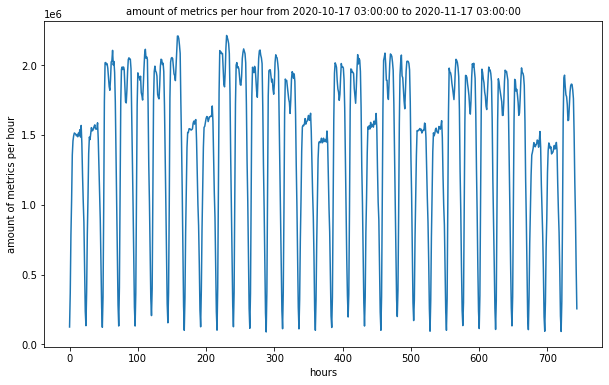

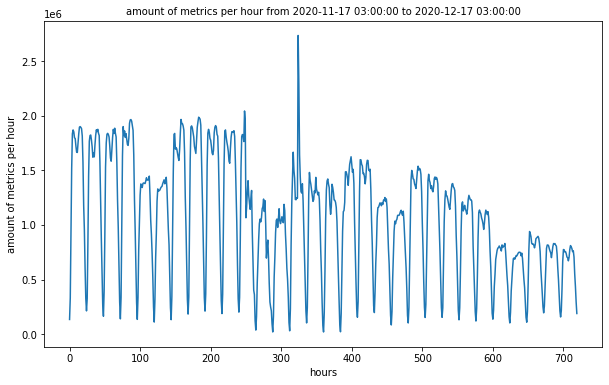

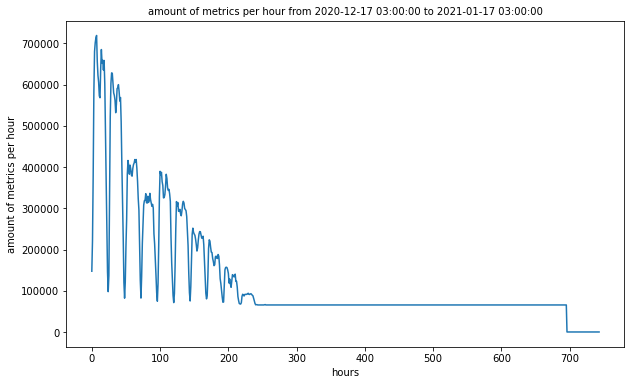

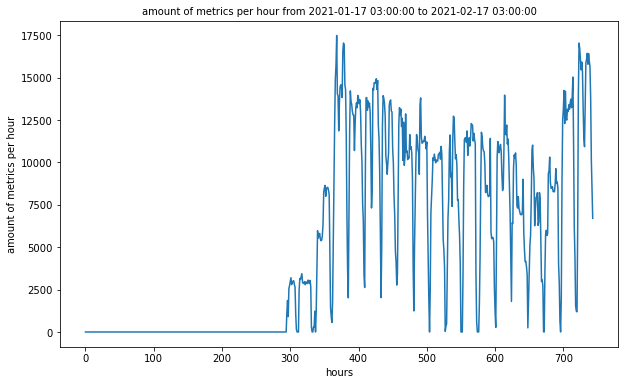

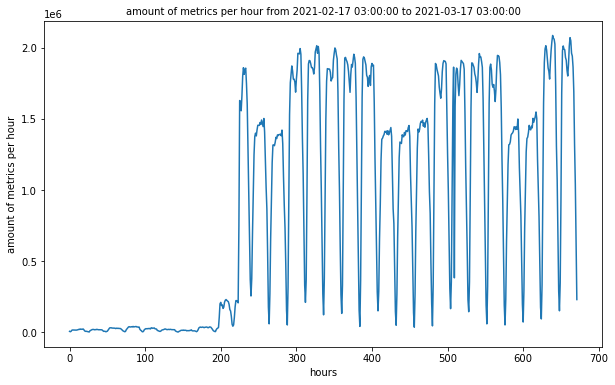

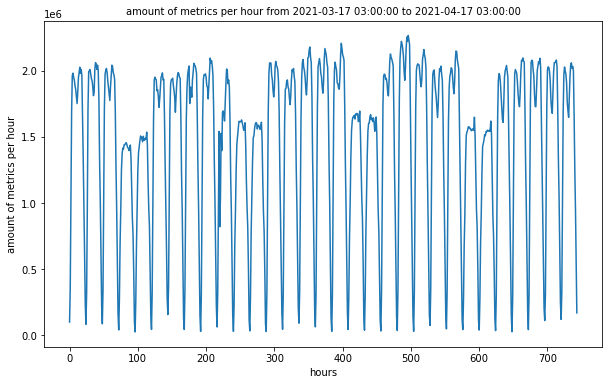

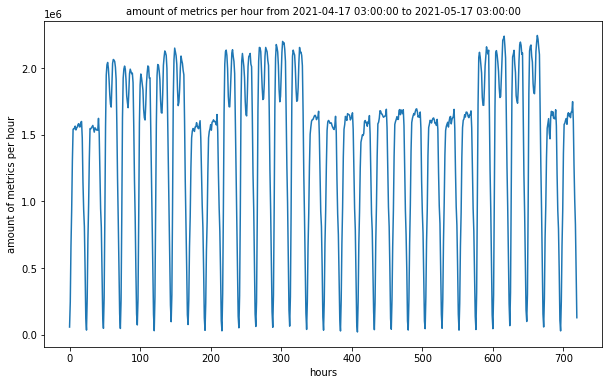

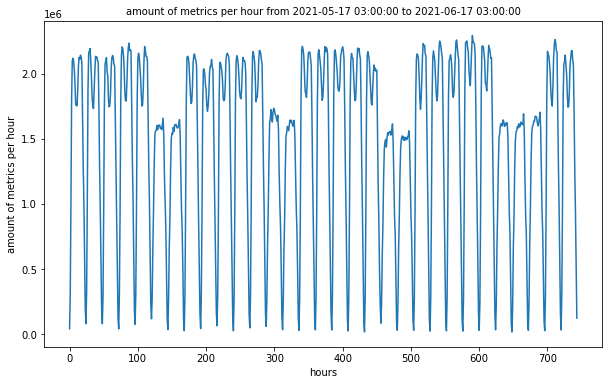

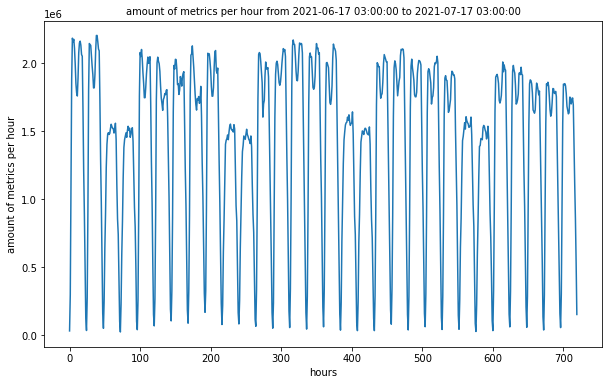

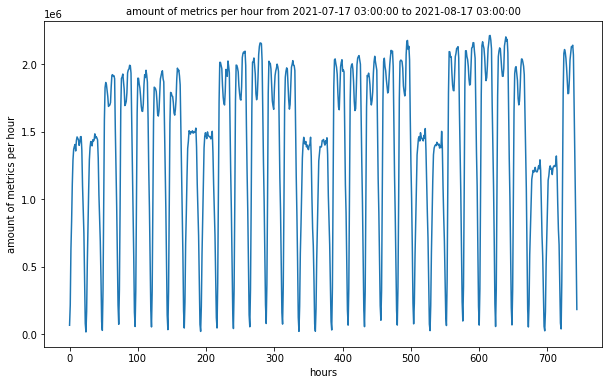

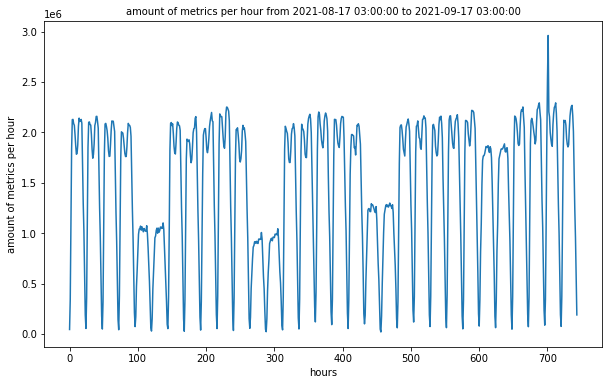

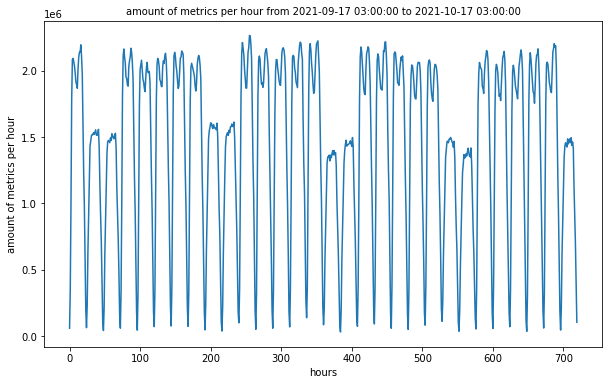

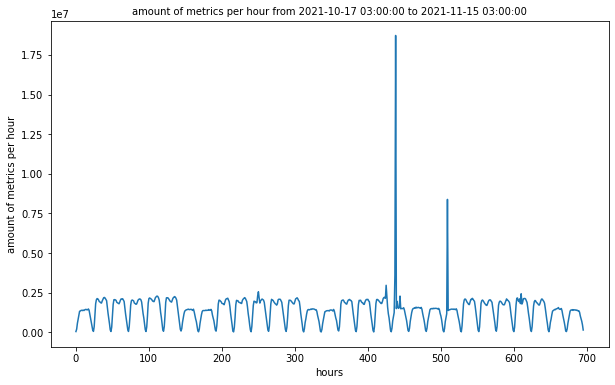

In [224]:
for i in range(len(date_month)):
    if i == 13:
        break
        
    X = []
    X = df['metrics'].loc[(df['from'] >= date_month[i]) & (df['from'] < date_month[i+1])]
    
    plt.figure(figsize=(10, 6))
    plt.plot(range(len(X)), X)
    plt.xlabel("hours", fontsize = 10)
    plt.ylabel(f"amount of metrics per hour", fontsize = 10)
    plt.title(f"amount of metrics per hour from {date_month[i]} to {date_month[i+1]}", fontsize = 10)
    
    plt.show()

3) Построим графики, где будет показано нарастающее количество метрик в час, то есть в конце мы увидем суммарное количество метрик в этом месяце

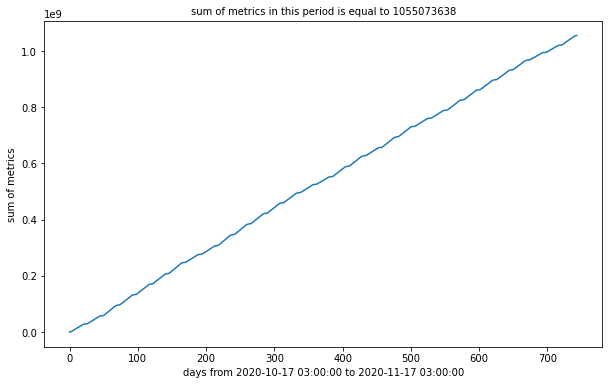

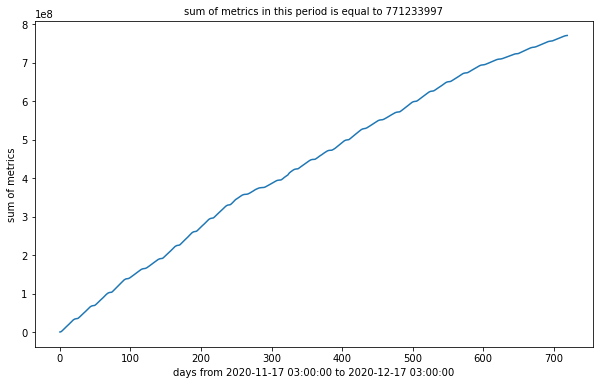

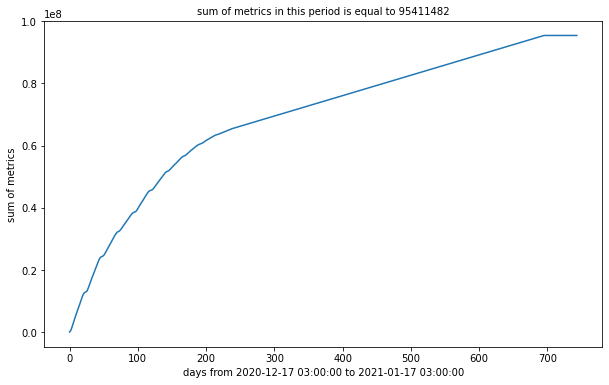

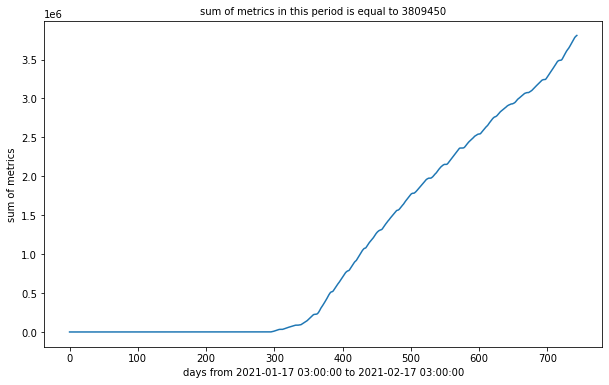

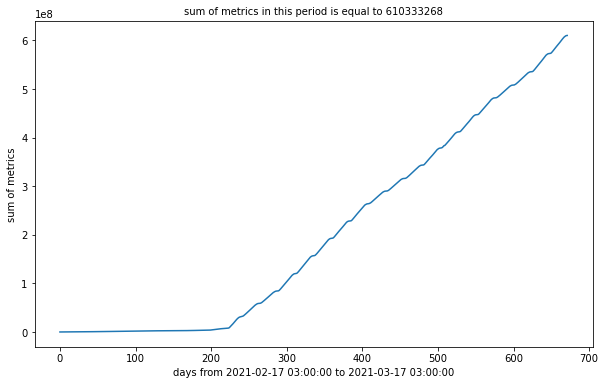

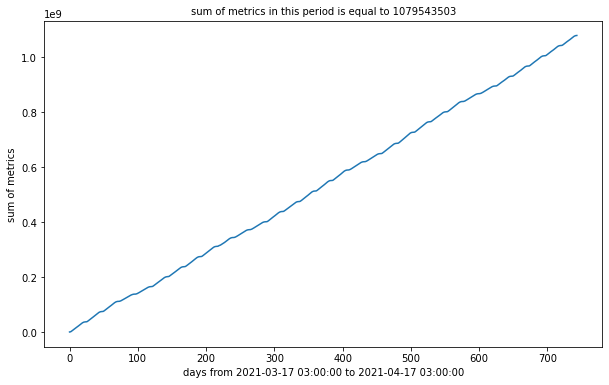

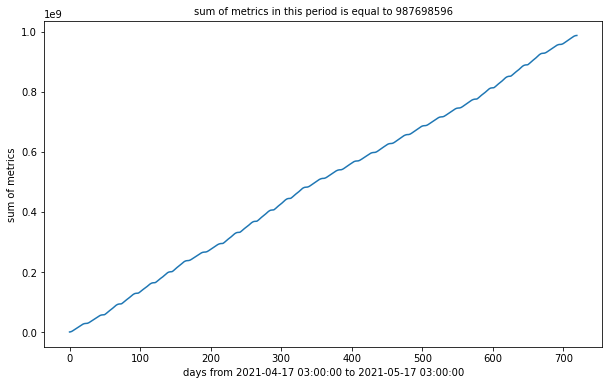

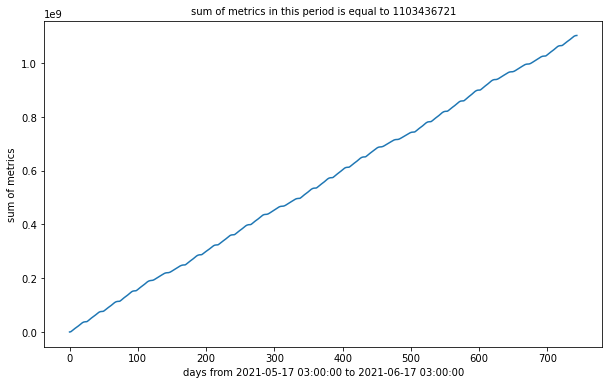

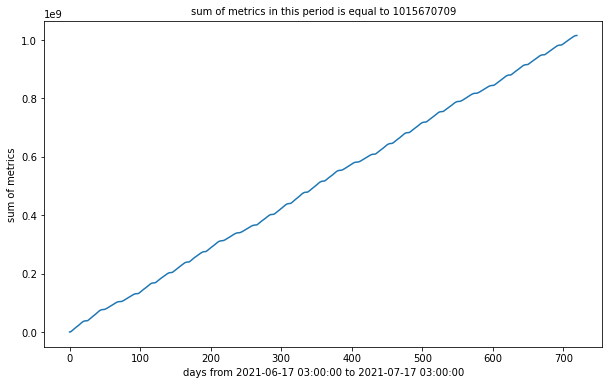

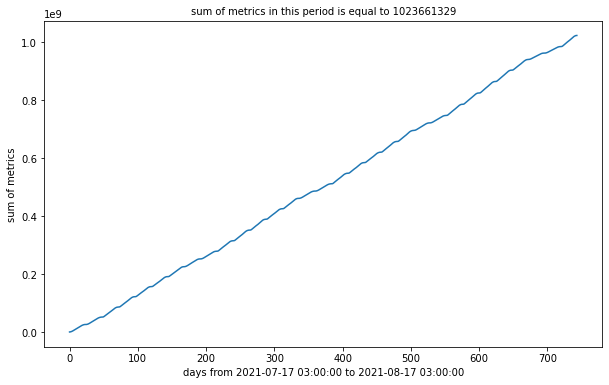

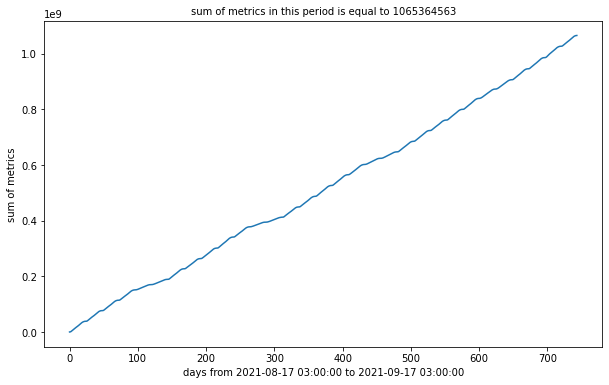

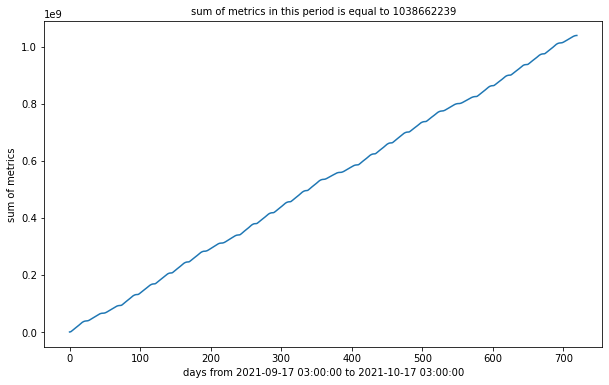

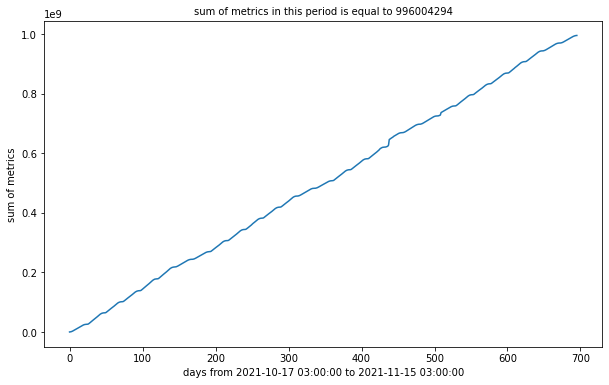

In [225]:
for i in range(len(date_month)):
    if i == 13:
        break
        
    val = 0
    x = []    
    X = []
    X = df['metrics'].loc[(df['from'] >= date_month[i]) & (df['from'] < date_month[i+1])]
    X = list(X)
    
    for j in range(len(X)):
        val += X[j]
        x.append(val)
    
    plt.figure(figsize=(10, 6))
    plt.plot(range(len(X)), x)
    plt.xlabel(f"days from {date_month[i]} to {date_month[i+1]}", fontsize = 10)
    plt.ylabel(f"sum of metrics", fontsize = 10)
    plt.title(f"sum of metrics in this period is equal to {x[len(x)-1]}", fontsize = 10)
    
    plt.show()

##### 2 вариант

1) Также создадим список с нужными датами

In [226]:
date_month_v2 = []

date_month_v2.append(datetime.fromisoformat('2020-10-17 03:00:00'))

for i in range(len(date_list)):
    if date_list[i].strftime('%d%H') == '0100':
        date_month_v2.append(date_list[i])

date_month_v2.append(datetime.fromisoformat('2021-11-15 03:00:00'))

date_month_v2

[datetime.datetime(2020, 10, 17, 3, 0),
 datetime.datetime(2020, 11, 1, 0, 0),
 datetime.datetime(2020, 12, 1, 0, 0),
 datetime.datetime(2021, 1, 1, 0, 0),
 datetime.datetime(2021, 2, 1, 0, 0),
 datetime.datetime(2021, 3, 1, 0, 0),
 datetime.datetime(2021, 4, 1, 0, 0),
 datetime.datetime(2021, 5, 1, 0, 0),
 datetime.datetime(2021, 6, 1, 0, 0),
 datetime.datetime(2021, 7, 1, 0, 0),
 datetime.datetime(2021, 8, 1, 0, 0),
 datetime.datetime(2021, 9, 1, 0, 0),
 datetime.datetime(2021, 10, 1, 0, 0),
 datetime.datetime(2021, 11, 1, 0, 0),
 datetime.datetime(2021, 11, 15, 3, 0)]

2) посмтроим графики, где будет показано количество метрик за каждый час

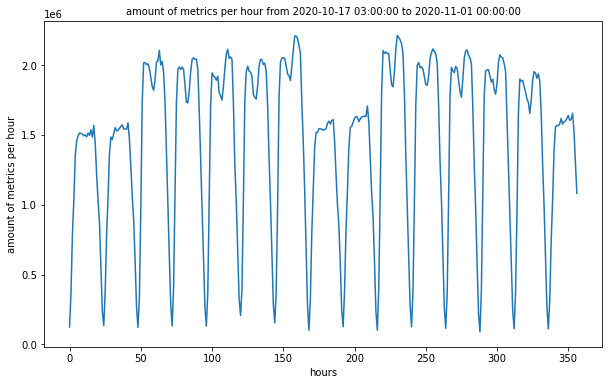

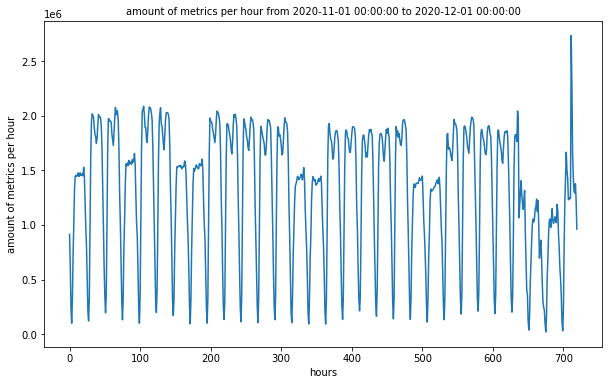

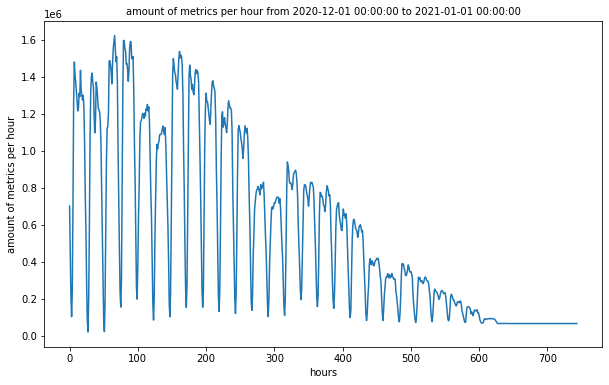

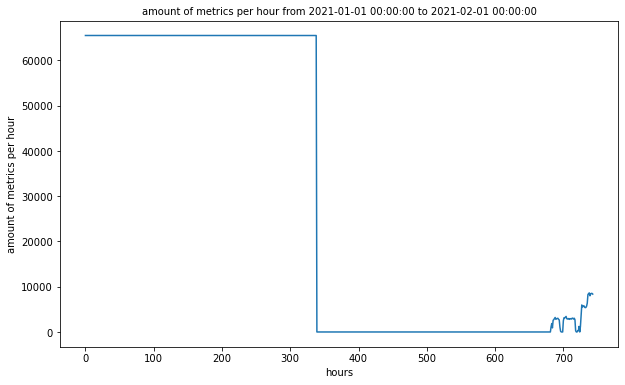

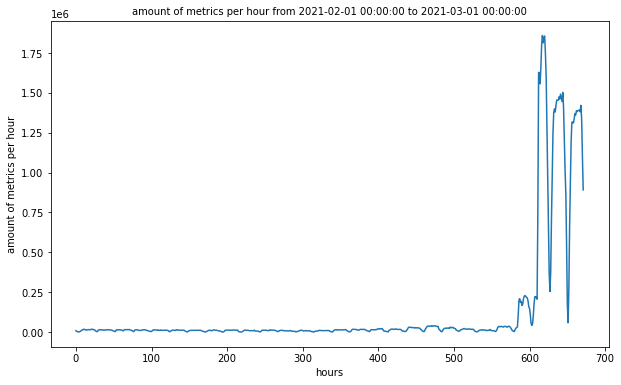

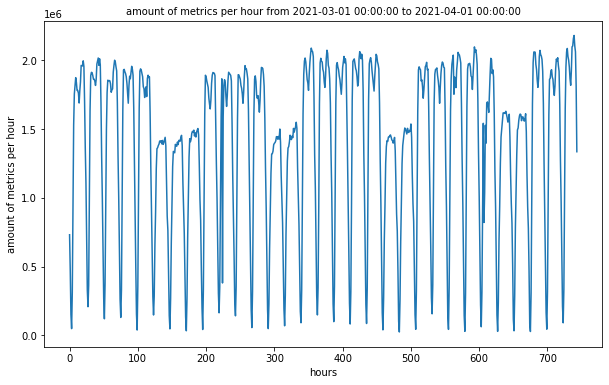

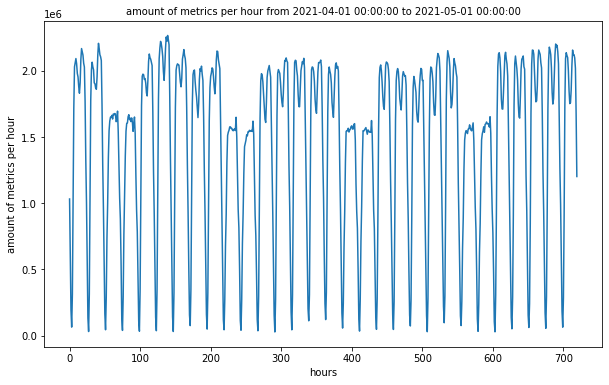

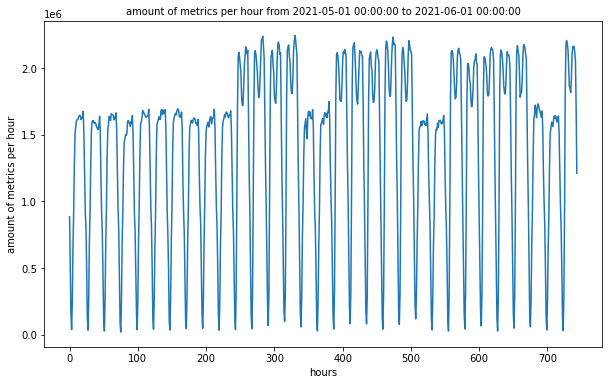

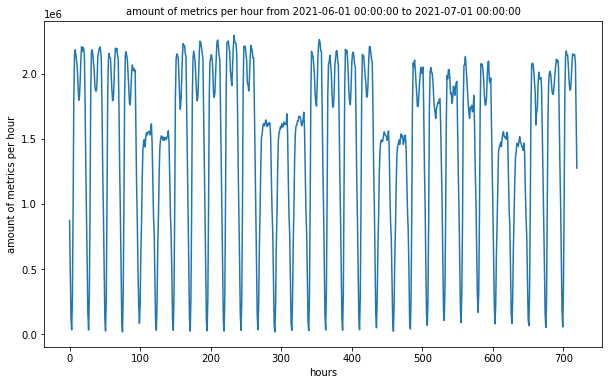

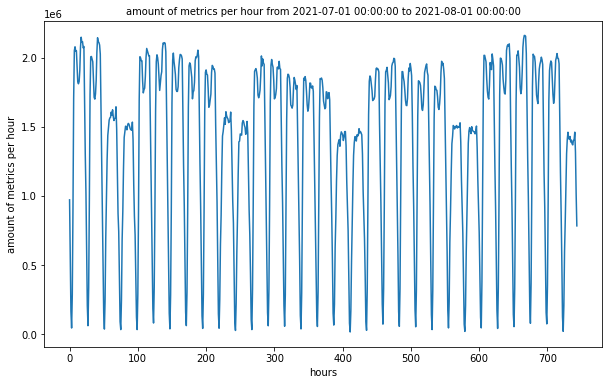

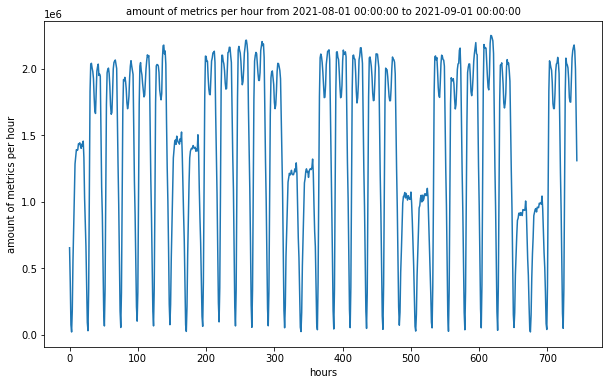

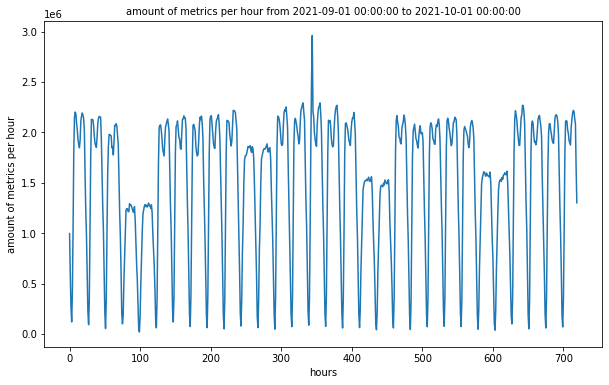

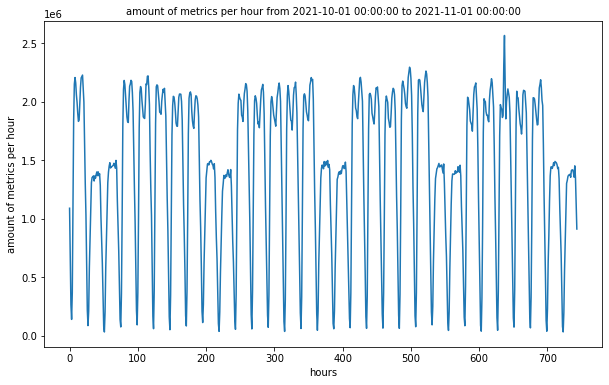

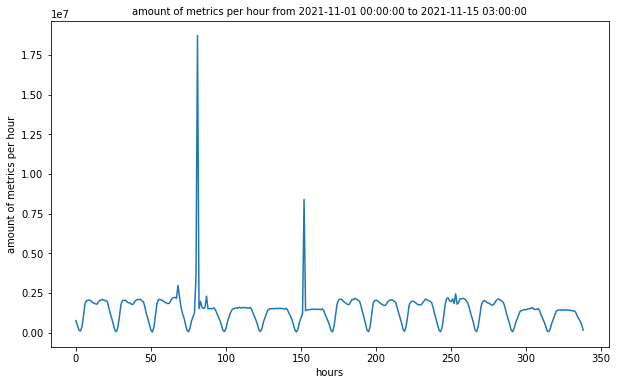

In [227]:
for i in range(len(date_month_v2)):
    if i == 14:
        break
        
    X = []
    X = df['metrics'].loc[(df['from'] >= date_month_v2[i]) & (df['from'] < date_month_v2[i+1])]
    
    plt.figure(figsize=(10, 6))
    plt.plot(range(len(X)), X)
    plt.xlabel("hours", fontsize = 10)
    plt.ylabel(f"amount of metrics per hour", fontsize = 10)
    plt.title(f"amount of metrics per hour from {date_month_v2[i]} to {date_month_v2[i+1]}", fontsize = 10)
    
    plt.show()

3) Построим графики, где будет показано нарастающее количество метрик в час, то есть в конце мы увидем суммарное количество метрик в этом месяце

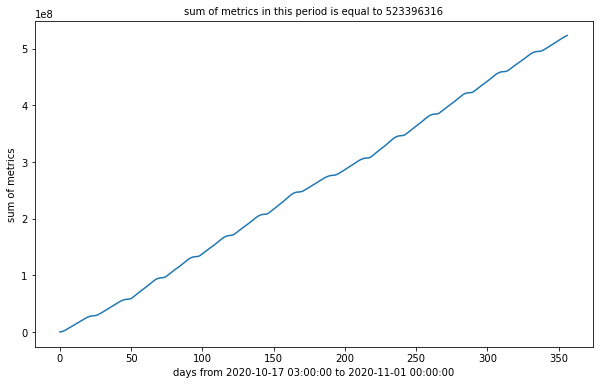

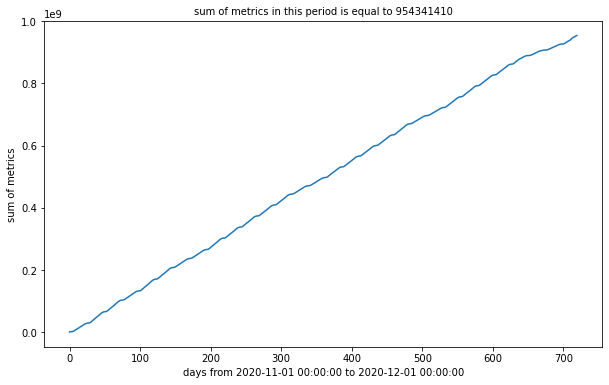

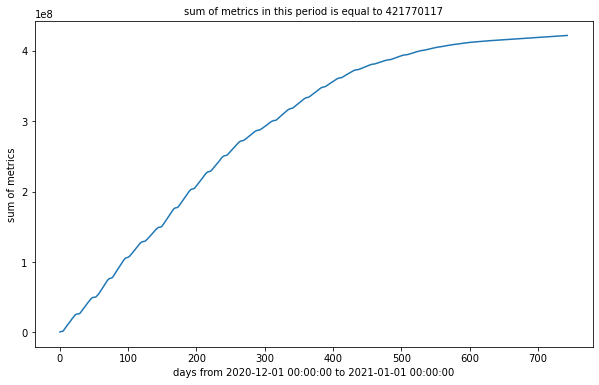

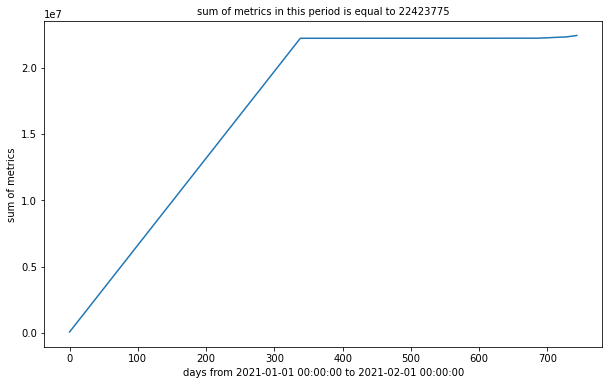

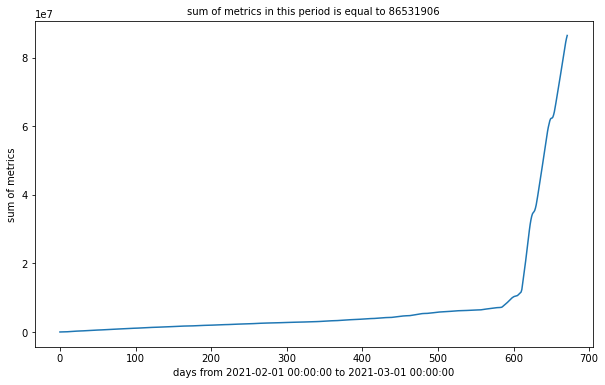

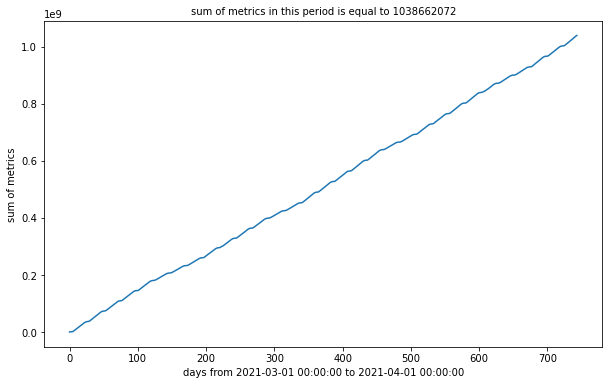

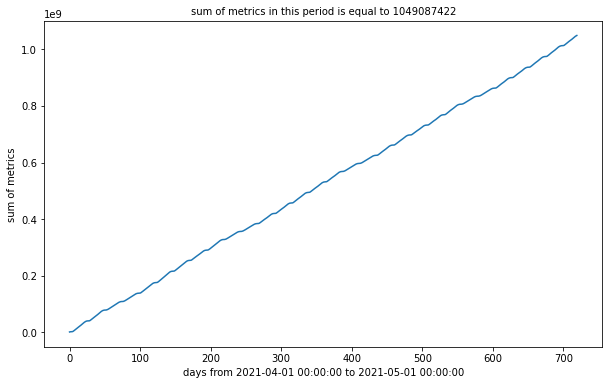

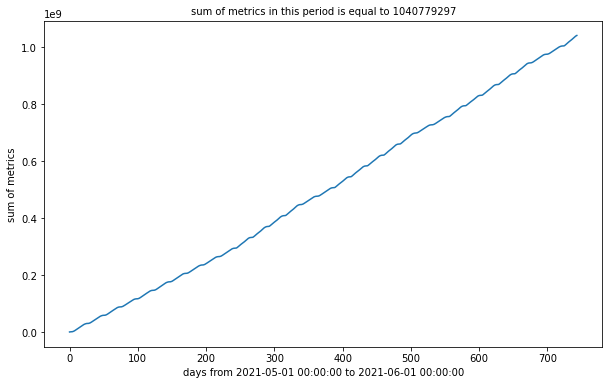

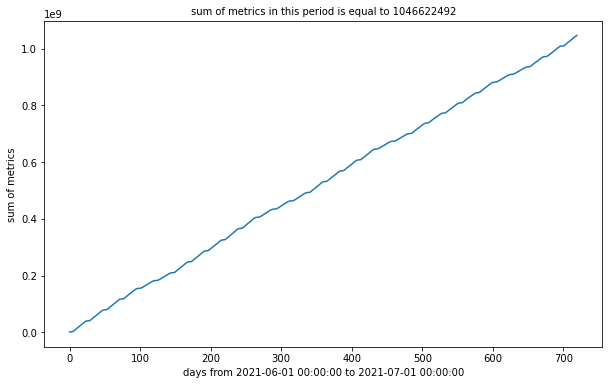

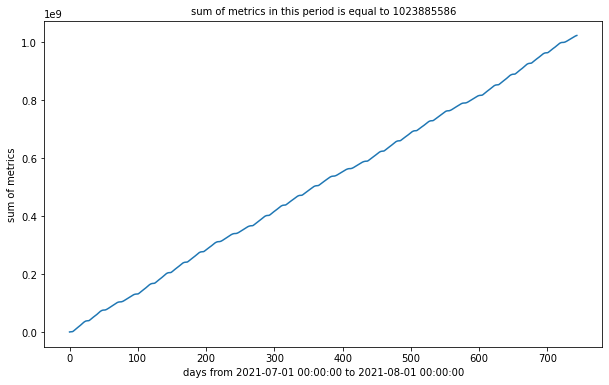

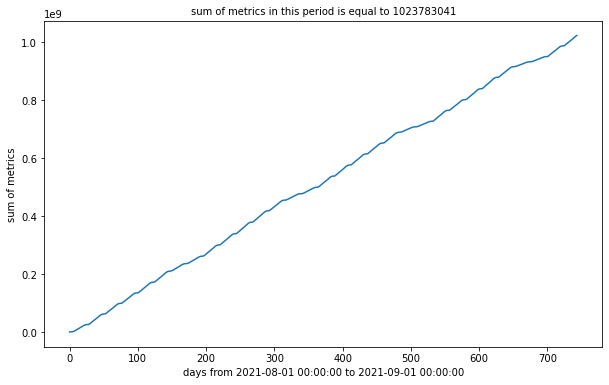

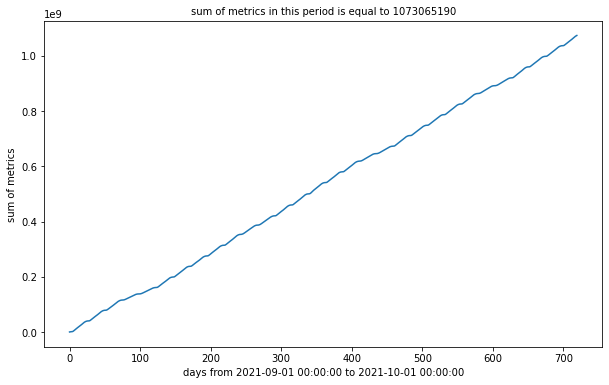

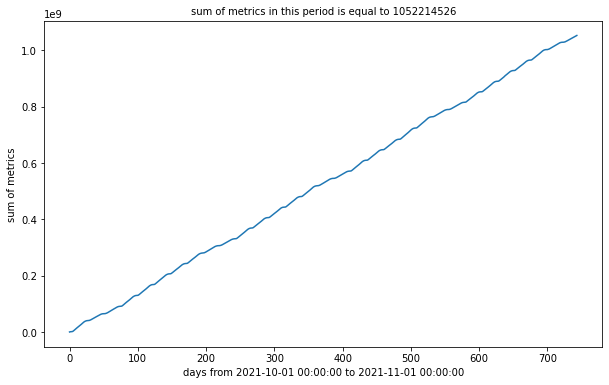

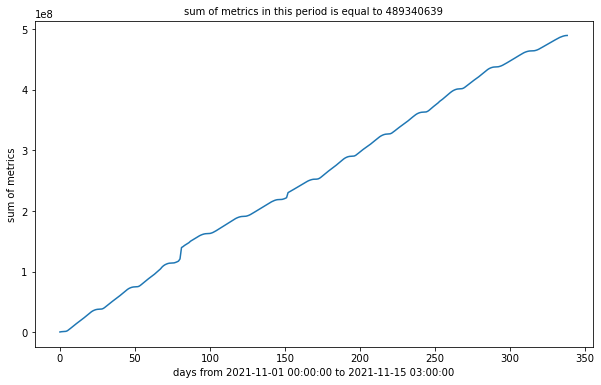

In [228]:
for i in range(len(date_month)):
    if i == 14:
        break
        
    val = 0
    x = []    
    X = []
    X = df['metrics'].loc[(df['from'] >= date_month_v2[i]) & (df['from'] < date_month_v2[i+1])]
    X = list(X)
    
    for j in range(len(X)):
        val += X[j]
        x.append(val)
    
    plt.figure(figsize=(10, 6))
    plt.plot(range(len(X)), x)
    plt.xlabel(f"days from {date_month_v2[i]} to {date_month_v2[i+1]}", fontsize = 10)
    plt.ylabel(f"sum of metrics", fontsize = 10)
    plt.title(f"sum of metrics in this period is equal to {x[len(x)-1]}", fontsize = 10)
    
    plt.show()